# Sparse Tensor Decomposition Chart Generator

In [2]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import sys
import os
sys.path.append("..")
from analysis.analysis import *

%load_ext autoreload
%autoreload 2

## SPLATT Baseline Reader

In [59]:
splatt_dir='../baseline/outputs/'

splatt_times_amazon_4nodes = read_splatt_trace(splatt_dir + 'amazon_decomposition_bench_4node_2threads.out')
splatt_times_reddit_4nodes = read_splatt_trace(splatt_dir + 'reddit_decomposition_bench_4node2threads.out')

amazon_splatt_meantime = np.mean(splatt_times_amazon_4nodes)
reddit_splatt_meantime = np.mean(splatt_times_reddit_4nodes)

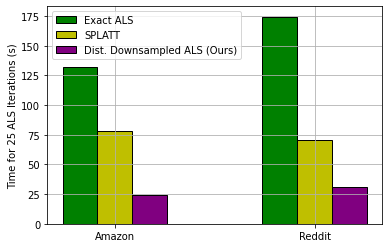

In [61]:
baseline_exp_dir='../data/splatt_comparison_runs/'

amazon_baselines = get_experiments(baseline_exp_dir + 'amazon.out')

total_time_exact_amazon = np.sum([amazon_baselines[0]['Timers'][el] for el in amazon_baselines[0]['Timers']])
total_time_sketched_amazon = np.sum([amazon_baselines[1]['Timers'][el] for el in amazon_baselines[1]['Timers']])

reddit_baselines = get_experiments(baseline_exp_dir + 'reddit.out')

total_time_exact_reddit = np.sum([reddit_baselines[0]['Timers'][el] for el in reddit_baselines[0]['Timers']])
total_time_sketched_reddit = np.sum([reddit_baselines[1]['Timers'][el] for el in reddit_baselines[1]['Timers']])

fig,ax=plt.subplots()

bar_width = 0.35
offset = 2.0
ngroups=1
index = np.arange(ngroups)
ax.bar([0, offset], [total_time_exact_amazon, total_time_exact_reddit], bar_width, color='g', label='Exact ALS', edgecolor='black')
ax.bar([bar_width, offset + bar_width], [amazon_splatt_meantime * 25, reddit_splatt_meantime * 25], bar_width, color='y', label='SPLATT', edgecolor='black')
ax.bar([2 * bar_width, offset + 2 * bar_width], [total_time_sketched_amazon, total_time_sketched_reddit], bar_width, color='purple', label='Dist. Downsampled ALS (Ours)', edgecolor='black')

plt.grid(True)
plt.xticks([bar_width, offset + bar_width])
ax.set_xticklabels(["Amazon", "Reddit"])
plt.ylabel("Time for 25 ALS Iterations (s)")
plt.legend()
fig.show()
fig.savefig("../analysis/figures/splatt_comparison.pdf", bbox_inches='tight')

([<matplotlib.axis.XTick at 0x148c1bed4f10>], [Text(0, 0, '')])

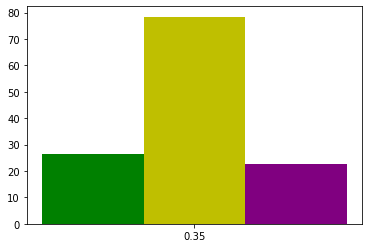

In [68]:
print(normalized_time_exact_amazon)

87.96939277648926


In [63]:
amazon_baselines[0]['Loss Iterations'][-1]

29

# Accuracy Table Generator

Median Fit for ../data/baseline_runs/amazon.out: 0.33738328859465216


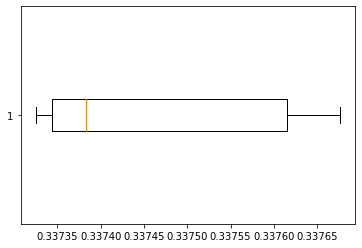

In [62]:
exp_dir='../data/baseline_runs/'

def get_mean_accuracies(path):
    exps = get_experiments(path)
    max_accuracies = []
    
    for exp in exps:
        max_accuracies.append(np.max(exp["Loss Values"]))
        
    plt.boxplot(max_accuracies, vert=False)
    print(f"Median Fit for {path}: {np.median(max_accuracies)}")
    
get_mean_accuracies(exp_dir + 'amazon.out')

Median Fit for ../data/baseline_runs/reddit.out: 0.05886066358229014


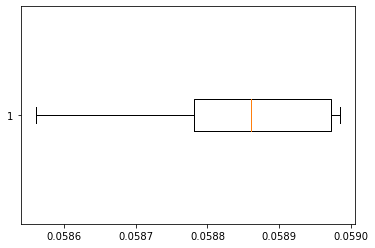

In [12]:
exp_dir='../data/baseline_runs/'

    
get_mean_accuracies(exp_dir + 'reddit.out')

Median Fit for ../data/baseline_runs/uber.out: 0.18901287580865755


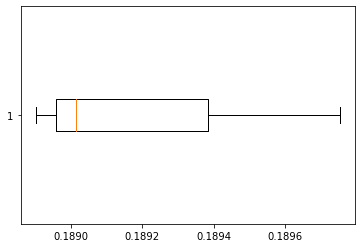

In [17]:
exp_dir='../data/baseline_runs/'

def get_mean_accuracies(path):
    exps = get_experiments(path)
    max_accuracies = []
    
    for exp in exps:
        max_accuracies.append(np.max(exp["Loss Values"]))
        
    plt.boxplot(max_accuracies, vert=False)
    print(f"Median Fit for {path}: {np.median(max_accuracies)}")
    
get_mean_accuracies(exp_dir + 'uber.out')

# Tensor Dimension Reader

In [33]:
import h5py

f = h5py.File('/pscratch/sd/v/vbharadw/tensors/caida_large.hdf5', 'r')
f['VALUES']

<HDF5 dataset "VALUES": shape (10339696053,), type "<f8">

# Scaling Experiment Chart Generator

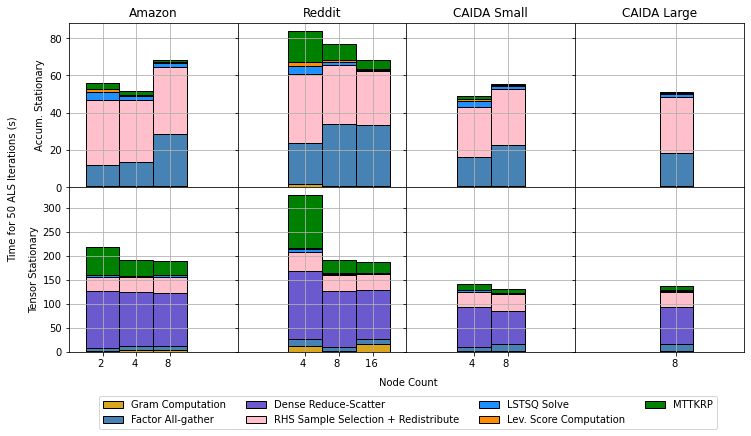

In [18]:
exp_dir='../data/scaling_runs/'

def timer_processor(time_dicts):
    outputs = []
    for el in time_dicts:
        if "Pre-optimizer Statistics" in el and el["Pre-optimizer Statistics"] is not None:
            pre_stats = el["Pre-optimizer Statistics"]
            for key in pre_stats['Timers'].keys():
                el['Timers'][key] += pre_stats['Timers'][key]
            
        output_map = {}
        output_map["Gram Computation"] = el["Gram Matrix Computation"]
        output_map["Factor All-gather"] = el["Slice All-gather"] + el["Sample Allgather"] + el["Sample Inflation"]
        output_map["Dense Reduce-Scatter"] = el["Slice Reduce-Scatter"]
        output_map["RHS Sample Selection + Redistribute"] = el["Nonzero Filtering + Redistribute"]
        output_map["LSTSQ Solve"] = el["Gram LSTSQ Solve"]
        output_map["Lev. Score Computation"] = el["Leverage Score Computation"]
        output_map["MTTKRP"] = el["MTTKRP"]
        outputs.append(output_map)
        
    return outputs

exps_reddit = get_experiments(exp_dir + 'reddit.out')
time_data = [exp['Timers'] for exp in exps_reddit]
time_data = timer_processor(time_data)
        

fig = plt.figure()
scale = 1.1
fig.set_size_inches(11 * scale, 5.5 * scale)
spec = fig.add_gridspec(2, 4, wspace=0, hspace=0.0)
axs = [[fig.add_subplot(spec[i, j]) for j in range(4)] for i in range(2)]

corner = [(0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3)]
lower_border = [(0, 1), (1, 1), (0, 2), (0, 3), (1, 2), (1, 3)]
top_right = [(0, 1), (0, 2), (0, 3)]
bottom_right = [(1, 1), (1, 2), (1, 3)]

axs[1][0].sharex(axs[0][0])
axs[1][1].sharex(axs[0][1])
axs[1][2].sharex(axs[0][2])
axs[1][3].sharex(axs[0][3])

for (x, y) in [(0, 0), (0, 1), (0, 2), (0, 3)]:
    axs[x][y].set_xlim((-0.25, 1.0))
    
for (x, y) in top_right:
    axs[x][y].sharey(axs[0][0])

for (x, y) in bottom_right:
    axs[x][y].sharey(axs[1][0])
    
for (x, y) in lower_border:
    axs[x][y].label_outer()

colors = ['goldenrod', 'steelblue', 'slateblue', 'pink', 'dodgerblue', 'darkorange', 'green']

ax = axs[0][0]
ax.set_ylabel("Accum. Stationary")
ax.set_title("Amazon")
exps_amazon = get_experiments(exp_dir + 'amazon.out')
time_data = [exp['Timers'] for exp in exps_amazon]
time_data = timer_processor(time_data)
make_stacked_barchart(ax, [0.0,0.25,0.5], 0.25, time_data, list(time_data[0].keys()), [f"{exp['Processor Count'] // 128} " for exp in exps_amazon], colors=colors)

ax = axs[1][0]
ax.set_ylabel("Tensor Stationary")
exps_amazon = get_experiments(exp_dir + 'amazon_tensor_stationary.out')
time_data = [exp['Timers'] for exp in exps_amazon]
time_data = timer_processor(time_data)
make_stacked_barchart(ax, [0.0,0.25,0.5], 0.25, time_data, list(time_data[0].keys()), [f"{exp['Processor Count'] // 128} " for exp in exps_amazon], colors=colors)

ax = axs[0][1]
ax.set_title("Reddit")
exps_reddit = get_experiments(exp_dir + 'reddit.out')[:-1]
time_data = [exp['Timers'] for exp in exps_reddit]
time_data = timer_processor(time_data)
make_stacked_barchart(ax, [0.25,0.50,0.75], 0.25, time_data, list(time_data[0].keys()), [f"{exp['Processor Count'] // 128} " for exp in exps_reddit], colors=colors)

ax = axs[1][1]
exps_reddit = get_experiments(exp_dir + 'reddit_tensor_stationary.out')
time_data = [exp['Timers'] for exp in exps_reddit]
time_data = timer_processor(time_data)
make_stacked_barchart(ax, [0.25,0.50,0.75], 0.25, time_data, list(time_data[0].keys()), [f"{exp['Processor Count'] // 128} " for exp in exps_reddit], colors=colors)

ax = axs[0][2]
ax.set_title("CAIDA Small")
exps_caida = get_experiments(exp_dir + 'caida_small.out')
time_data = [exp['Timers'] for exp in exps_caida]
time_data = timer_processor(time_data)
make_stacked_barchart(ax, [0.25,0.50], 0.25, time_data, list(time_data[0].keys()), [f"{exp['Processor Count'] // 128} " for exp in exps_caida], colors=colors)

ax = axs[1][2]
exps_caida = get_experiments(exp_dir + 'caida_small_tensor_stationary.out')
time_data = [exp['Timers'] for exp in exps_caida]
time_data = timer_processor(time_data)
make_stacked_barchart(ax, [0.25,0.50], 0.25, time_data, list(time_data[0].keys()), [f"{exp['Processor Count'] // 128} " for exp in exps_caida], colors=colors)

ax = axs[0][3]
ax.set_title("CAIDA Large")
exps_caida = get_experiments(exp_dir + 'caida_medium.out')
time_data = [exp['Timers'] for exp in exps_caida]
time_data = timer_processor(time_data)
make_stacked_barchart(ax, [0.50], 0.25, time_data, list(time_data[0].keys()), [f"{exp['Processor Count'] // 128} " for exp in exps_caida], colors=colors)

ax = axs[1][3]
exps_caida = get_experiments(exp_dir + 'caida_medium_tensor_stationary.out')
time_data = [exp['Timers'] for exp in exps_caida]
time_data = timer_processor(time_data)
make_stacked_barchart(ax, [0.50], 0.25, time_data, list(time_data[0].keys()), [f"{exp['Processor Count'] // 128} " for exp in exps_caida], colors=colors)

fig.text(0.515, 0.046, 'Node Count', ha='center')
fig.text(0.06, 0.336, 'Time for 50 ALS Iterations (s)', ha='center', rotation="vertical")


leg_handles, leg_labels = axs[0][0].get_legend_handles_labels()
fig.legend(leg_handles, leg_labels, bbox_to_anchor=(0.875, 0.035), ncol=4)
fig.show()
fig.savefig("../analysis/figures/scaling_breakdown.pdf", bbox_inches='tight')